# Building a Handwritten Digits Classifier

In this project, we'll explore the effectiveness of deep, feedforward neural networks at classifying images.

Scikit-learn contains a number of datasets pre-loaded with the library, within the namespace of sklearn.datasets. The dataset I will be working with comes from the load_digits() [function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html), which returns a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits

digits_data = load_digits()

In [2]:
digits_data.keys()

dict_keys(['DESCR', 'target', 'images', 'target_names', 'data'])

In [3]:
labels = pd.Series(digits_data['target'])

In [4]:
data = pd.DataFrame(digits_data['data'])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


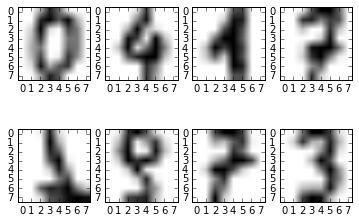

In [17]:
# Visualize some of the images in the dataset
# First row of plot = data rows 0, 100, 200, 300
# Second row of plot = data rows 1000, 1100, 1200, 1300
fig, ax = plt.subplots(2,4)
r = 0
for row in range(2):
    for col in range(4):
        ax[row, col].imshow(data.iloc[r].values.reshape(8,8), cmap='gray_r')
        r += 100
    r=1000
plt.show()

Lets start classifying images using basic ML algorithms before moving onto neural networks.

Linear and Logistic Regression make assumptions about linearity between the features and the output labels, which is not ideal for image classification. However, the K-Nearest Neighbors algorithm doesn't make any such assumptions, which allows it to capture nonlinearity in the data.

The K-Nearest Neighbors algorithm compares every unseen observation in the test set to all (or many with some implementations) training observations to look for similar (the 'nearest') observations. Then the algorithm finds the label with the most nearby observations ('neighbors') and assigns that as the prediction for the unseen observation

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def knn_train(num_neighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = num_neighbors)
    knn.fit(train_features, train_labels)
    return knn

def knn_test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    knn_accuracy = pd.DataFrame()
    knn_accuracy['actual_labels'] = test_labels
    knn_accuracy['predicted_labels'] = predictions
    accuracy = sum(knn_accuracy['actual_labels'] == knn_accuracy['predicted_labels']) / len(knn_accuracy)
    return accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits=4, random_state=1)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = knn_train(k, train_features, train_labels)
        accuracy = knn_test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies

# Test functions on two neighbors
np.mean(cross_validate(2))

0.9616010888393962

Using two neighbors, we were correctly able to predict approx. 96% of the test labels

Now, lets iterate through different values of k and plot the resulting accuracies.

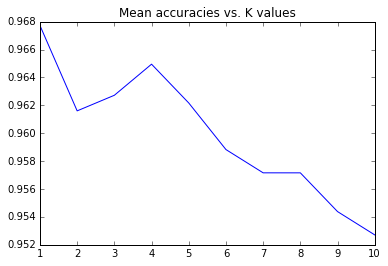

In [7]:
k_accuracies = []
k_values = list(range(1,11))
for k in k_values:
    k_accuracies.append(np.mean(cross_validate(k)))

plt.plot(k_values, k_accuracies)
plt.title('Mean accuracies vs. K values')
plt.show()

It appears that using a larger number of neighbors results in lower accuracies. Using one neighbor resulted in the largest accuracy. However, all of the accuracies for using 1 to 10 neighbors were over 95%. However, there are a few downsides to using KNN:
- High memory usage (you need to compare each unseen observation individually to all of the training data)
- No model representation to debug and explore

Now, lets try a neural network with a single hidden layer, using 4-fold cross validation.

In [8]:
from sklearn.neural_network import MLPClassifier

def nn_train(hls, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes = hls)
    mlp.fit(train_features, train_labels)
    return mlp

def nn_test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    nn_accuracy = pd.DataFrame()
    nn_accuracy['actual'] = test_labels
    nn_accuracy['predicted'] = predictions
    accuracy = sum(nn_accuracy['actual'] == nn_accuracy['predicted']) / len(nn_accuracy)
    return accuracy

def cross_validate(hls):
    fold_accuracies = []
    kf = KFold(n_splits=4, random_state=1)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = nn_train(hls, train_features, train_labels)
        fold_accuracies.append(nn_test(model, test_features, test_labels))
    return fold_accuracies

# Test functions on 4 neurons
np.mean(cross_validate((4,)))

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



0.6654503835684237

Using 4 hidden layers didn't have very good accuracy, and we even got a warning that the max number of iterations has been reached and the optimazation hasn't yet converged. 

Let's try testing it with 8, 16, 32, 64, 128, and 256 neurons and plot the accuracies:

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



0.8853637713437268
0.9159712942341005
0.9354454342984408
0.933772581044296
0.9410071764414749
0.9460121257114575


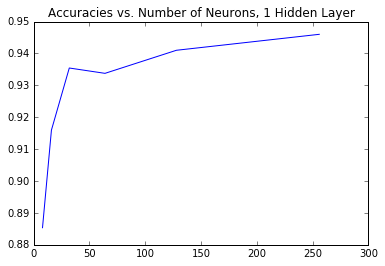

In [9]:
h_l_list = []
h_l = 8
for i in range(6):
    h_l_list.append(h_l)
    h_l *= 2
nn_accuracies = []

for n in h_l_list:
    accuracy = np.mean(cross_validate((n,)))
    nn_accuracies.append(accuracy)
    print(accuracy)
    
plt.plot(h_l_list, nn_accuracies)
plt.title('Accuracies vs. Number of Neurons, 1 Hidden Layer')
plt.show()

Once the number of neurons reaches 64, the calculations begin to take an excessively long time. 32 neurons didn't take substantially long, and predicted an accuracy of ~ 93.5%. Increasing the neurons to 256 increased the accuracy to ~ 94.6%. Given that k-nearest neighbors predicted an accuracy of ~ 96.7%, there doesn't seem to be any advantage of using a neural network with one hidden layer over the KNN approach, especially given the extra time it took to compute with a large number of neurons.

Now, lets try adding two hidden laters with 64, 128, and 256 neurons per layer, and plotting the results.

0.9426763177431329
0.9437886661717396
0.9610405840138581


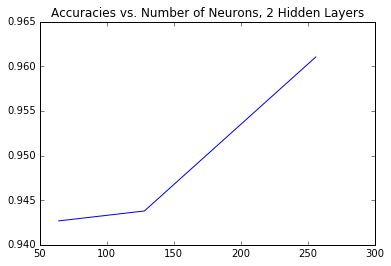

In [12]:
two_hl = [
    (64,64),
    (128,128),
    (256,256)
]
two_hl_acc = []
for n in two_hl:
    accuracy = np.mean(cross_validate(n))
    two_hl_acc.append(accuracy)
    print(accuracy)
    
plt.plot([64,128,256], two_hl_acc)
plt.title('Accuracies vs. Number of Neurons, 2 Hidden Layers')
plt.show()

Using two hidden layers with 128 neurons each increased the accuracy to over 96%, similar to the KNN approach. I am not too worried about overfitting because I am using 4 fold cross validation.

I will now try using three hidden layers, with 6 fold cross validation rather than 4 fold

In [15]:
def cross_validate(hls):
    fold_accuracies = []
    kf = KFold(n_splits=6, random_state=1)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = nn_train(hls, train_features, train_labels)
        fold_accuracies.append(nn_test(model, test_features, test_labels))
    return fold_accuracies

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



0.8809308807134895
0.9387922705314008
0.963277591973244


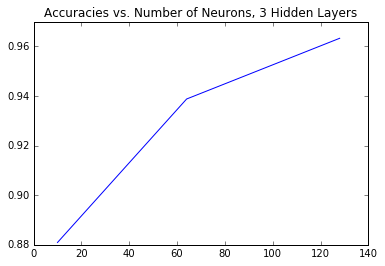

In [16]:
three_hl_list = [
    (10,10,10),
    (64,64,64),
    (128,128,128)
]
three_hl_acc = []
for n in three_hl_list:
    accuracy = np.mean(cross_validate(n))
    three_hl_acc.append(accuracy)
    print(accuracy)
    
plt.plot([10,64,128], three_hl_acc)
plt.title('Accuracies vs. Number of Neurons, 3 Hidden Layers')
plt.show()

Using three hidden layers improved our accuracy to ~ 96.3%, even when increasing the number of folds from 4 to 6.

Overall, increasing the number of hidden layers and the number of neurons seems to increase the accuracy.


Let's take a look at some of the numbers where it predicted wrong, to see if we can discern why that was the case

In [23]:
split = int(len(data)*.8)
train_features, test_features = data[0:split], data[split:]
train_labels, test_labels = labels[0:split], labels[split:]    
mlp = MLPClassifier(hidden_layer_sizes=(128,128,128))
mlp.fit(train_features, train_labels)
predictions = mlp.predict(test_features)
nn_accuracy = pd.DataFrame()
nn_accuracy['actual'] = test_labels
nn_accuracy['predicted'] = predictions
incorrect_features = test_features[nn_accuracy['actual'] != nn_accuracy['predicted']]
incorrect_labels = test_labels[nn_accuracy['actual'] != nn_accuracy['predicted']]

In [26]:
print(incorrect_features.shape[0])


26


/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



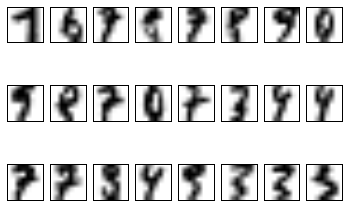

In [30]:
fig, ax = plt.subplots(3,8)
r=0
for row in range(3):
    for col in range(8):
        ax[row, col].imshow(incorrect_features.iloc[r].values.reshape(8,8), cmap='gray_r')
        ax[row, col].tick_params(left=False, bottom=False, top=False, right=False,
                                 labelleft=False, labelbottom=False)
        ax[row,col].legend()
        r+=1
plt.show()


Many of these numbers were not written nearly, and sort of resemble other numbers than they were supposed to predict. For instance, many of the 7's look like 1's, many of the 3's look like 7's, and many of the 4's look like 9's. I would expect that as we increase the number of hidden layers and neurons, the algorithm would predict these more accurately. 